In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [2]:
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils
from keras.regularizers import l2
from keras.initializers import RandomNormal, VarianceScaling

In [3]:
IMG_WIDTH=400
IMG_HEIGHT=600
inputShape = (400,600,1)


In [5]:
def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image= cv2.imread(image_path, cv2.COLOR_BGR2GRAY)    # input gray image  
            
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA) # resize the image
            img_blur = cv2.GaussianBlur(image, (3, 3), 0) # Gaussian blur the image
            edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)  # Canny Edge Detection
            kernel = np.ones((5,5), np.uint8)
            image = cv2.dilate(edges, kernel, iterations=1) #Dialating the edges
            
            image=np.array(image)
            temp = np.zeros((IMG_WIDTH,IMG_HEIGHT,1)) #Resizing the image
            temp[:,:,0] = image
            image = temp
            image = image.astype('float32')
            image /= 255 
            image
             
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array, class_name

In [6]:
# extract the image array and class name
X_train, y_train =create_dataset(r'Train1') # Creating train dataset
X_test, y_test =create_dataset(r'Test') # Creating test dataset

In [7]:
print(X_train[0].shape) # X train shape

(400, 600, 1)


In [8]:
train_dict={k: v for v, k in enumerate(np.unique(y_train))}
train_val=  [train_dict[y_train[i]] for i in range(len(y_train))]
test_dict={k: v for v, k in enumerate(np.unique(y_test))}
test_val=  [test_dict[y_test[i]] for i in range(len(y_test))]

In [9]:
cars = np.unique(y_test)

In [11]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=inputShape, padding='valid', kernel_regularizer=l2(0.00004),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='valid', kernel_regularizer=l2(0.00004),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3,3),padding='valid', kernel_regularizer=l2(0.00004),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
# final activation is softmax, tuned to the number of classes/labels possible
model.add(Dense(len(train_dict), activation='softmax'))

# optimizer will be a stochastic gradient descent
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 398, 598, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 199, 299, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 197, 297, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 148, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 146, 128)      73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 73, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 448512)            0

In [12]:
history = model.fit(np.array(X_train), np.array(train_val), batch_size=4, epochs=15, verbose=1, validation_data=(np.array(X_test), np.array(test_val)))

Epoch 1/15
215/215 [==============================] - 300s 1s/step - loss: 2.8927 - sparse_categorical_accuracy: 0.0970 - val_loss: 2.7976 - val_sparse_categorical_accuracy: 0.1810
Epoch 2/15
215/215 [==============================] - 286s 1s/step - loss: 2.3663 - sparse_categorical_accuracy: 0.2913 - val_loss: 2.7406 - val_sparse_categorical_accuracy: 0.1714
Epoch 3/15
215/215 [==============================] - 302s 1s/step - loss: 1.6365 - sparse_categorical_accuracy: 0.5145 - val_loss: 2.7412 - val_sparse_categorical_accuracy: 0.2762
Epoch 4/15
215/215 [==============================] - 287s 1s/step - loss: 0.8610 - sparse_categorical_accuracy: 0.7693 - val_loss: 2.9359 - val_sparse_categorical_accuracy: 0.2476
Epoch 5/15
215/215 [==============================] - 288s 1s/step - loss: 0.3942 - sparse_categorical_accuracy: 0.8880 - val_loss: 3.2940 - val_sparse_categorical_accuracy: 0.2286
Epoch 6/15
215/215 [==============================] - 281s 1s/step - loss: 0.2586 - sparse_cate

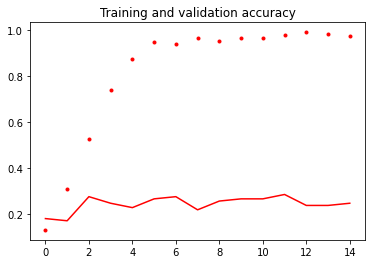

4/4 [==============================] - 7s 2s/step - loss: 4.1035 - sparse_categorical_accuracy: 0.2476
Accuracy test: 24.76%


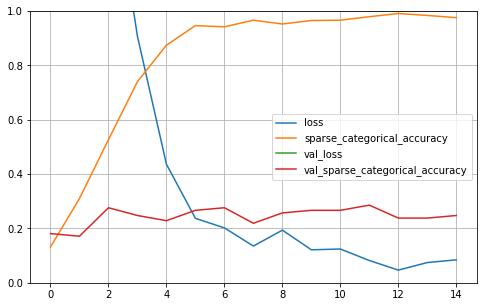

In [13]:
def plot_training(history):
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    # plt.figure()
    # plt.plot(epochs, loss, 'r.')
    # plt.plot(epochs, val_loss, 'r-')
    # plt.title('Training and validation loss')
    plt.show()
    
plot_training(history)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]

#print("Saved model to disk")
scores = model.evaluate(np.array(X_test), np.array(test_val)) # let's look at the accuracy on the test set
print("Accuracy test: %.2f%%" % (scores[1]*100))

In [14]:
from sklearn.metrics import precision_recall_fscore_support as prfs

# Preparing for metrics check-up on the test set, may take a while...
# output = np.array(model.predict(np.array(X_test, np.float32)))
# Y_pred = model.predict_classes(X_test)
Y_pred = (model.predict(np.array(X_test)))

y_pred = [out.argmax() for out in Y_pred]
# print(y_pred)

Model Report
              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.17      0.20      0.18         5
           2       0.00      0.00      0.00         6
           3       1.00      0.20      0.33         5
           4       0.50      0.17      0.25         6
           5       0.14      0.29      0.19         7
           6       1.00      0.14      0.25         7
           7       0.25      0.20      0.22         5
           8       0.33      0.20      0.25         5
           9       0.20      0.20      0.20         5
          10       1.00      0.20      0.33         5
          11       0.33      0.14      0.20         7
          12       0.67      0.40      0.50         5
          13       0.10      0.40      0.16         5
          14       0.18      0.40      0.25         5
          15       0.50      0.67      0.57         6
          16       0.50      0.11      0.18         9
          17  

C:\Users\gowri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gowri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gowri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


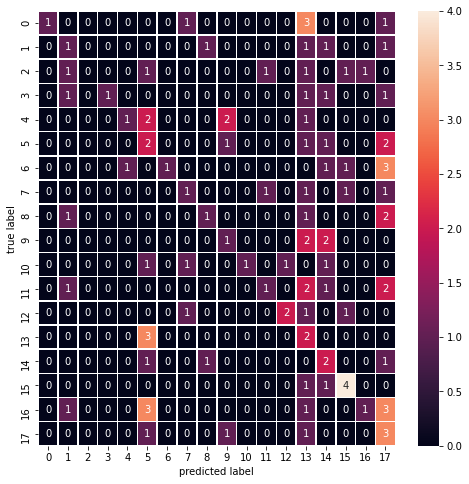

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns #for better and easier plots

def report_and_confusion_matrix(label, prediction):
    print("Model Report")
    print(classification_report(label, prediction))
    score = accuracy_score(label, prediction)
    print("Accuracy : "+ str(score))
    
    ####################
    fig, ax = plt.subplots(figsize=(8,8)) #setting the figure size and ax
    mtx = confusion_matrix(label, prediction)
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,  cbar=True, ax=ax) #create a heatmap with the values of our confusion matrix
    plt.ylabel('true label')
    plt.xlabel('predicted label')

report_and_confusion_matrix(test_val, np.array(y_pred))

In [16]:
# But let's check per class, too - assuming that larger datasets will be having higher metrics
precision_, recall_, f1_, support_ = prfs(test_val, y_pred, average=None)


C:\Users\gowri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
output = np.array(model.predict(np.array(X_test, np.float32)))
y_pred = [out.argmax() for out in output]
classes = list(train_dict.keys())
pred = [classes[v] for v in y_pred]
test = [classes[v] for v in test_val]
correct = 0
for i in range(len(test_val)):
    if pred[i] == test[i]:
        correct += 1
accuracy = correct / len(test_val)

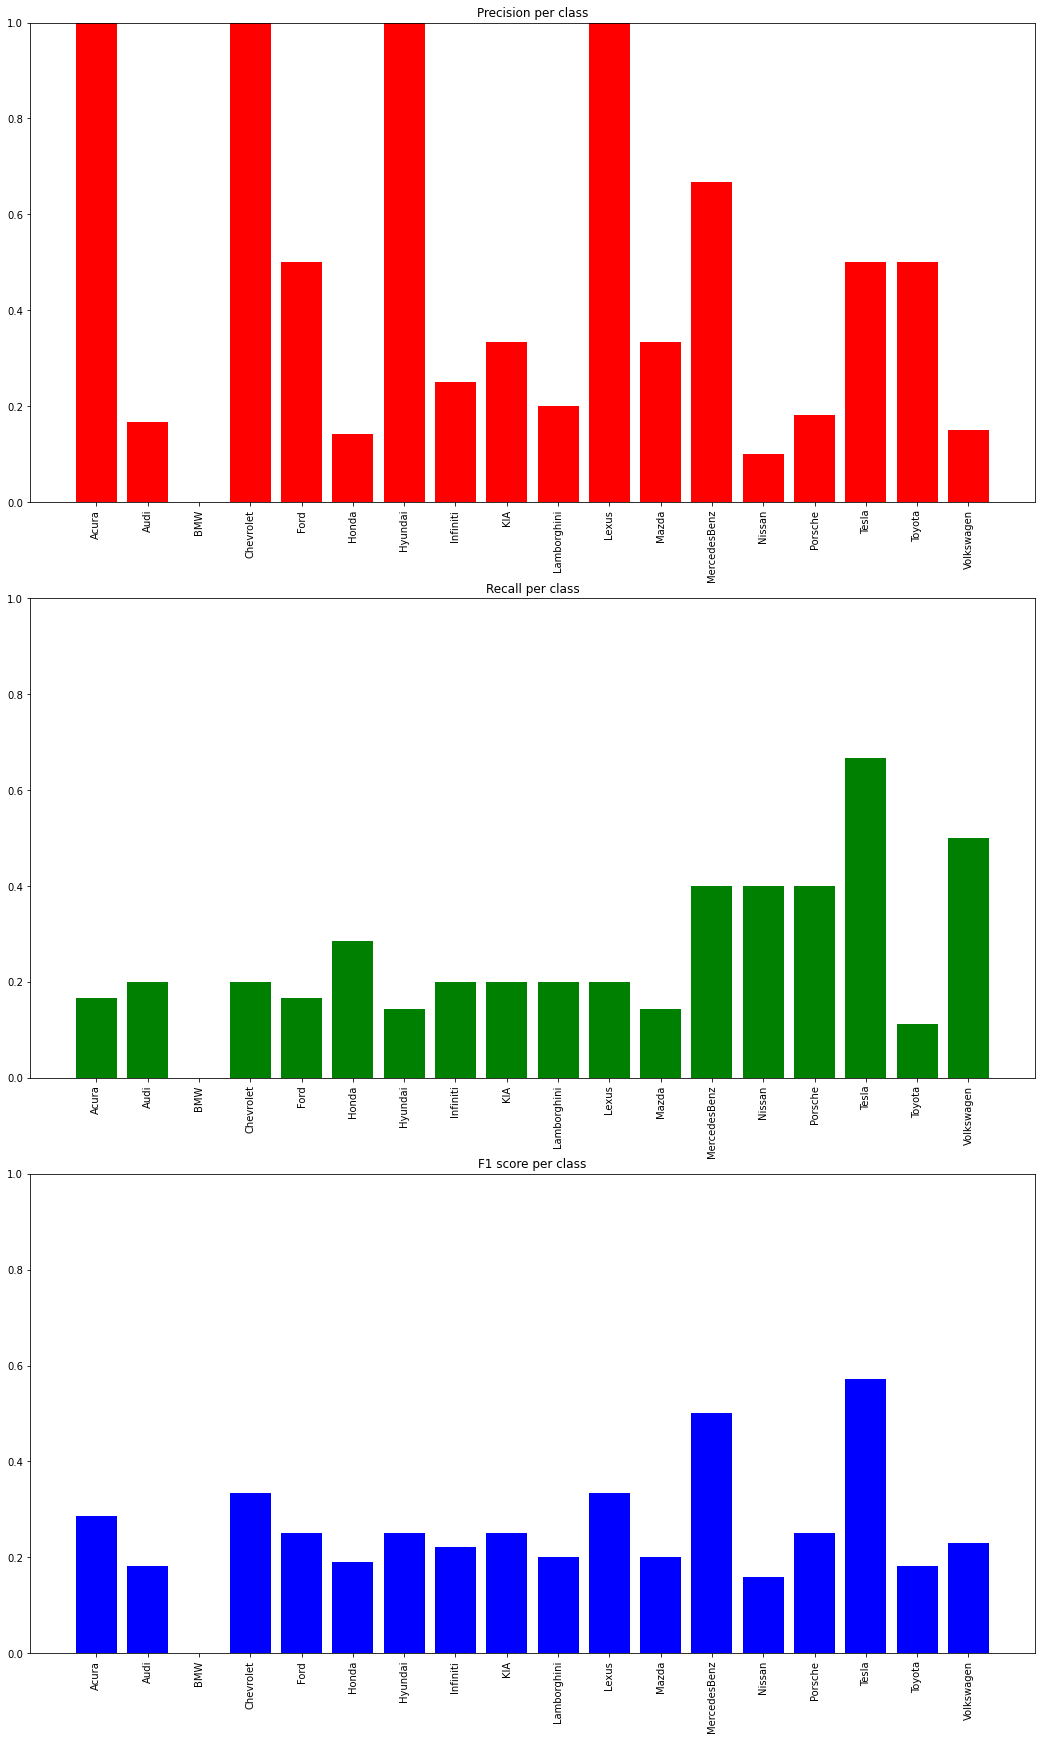

In [18]:
# Box plot of precision, recall and F1 score
plt.subplots(figsize=(18,30))
x = range(len(cars))
plt.subplot(311)
plt.title('Precision per class')
plt.ylim(0.0, 1.00)
plt.bar(x, precision_, color='Red')
plt.xticks(x, cars, rotation = 90)
plt.subplot(312)
plt.title('Recall per class')
plt.ylim(0.0, 1.00)
plt.bar(x, recall_, color='Green')
plt.xticks(x, cars, rotation = 90)
plt.subplot(313)
plt.title('F1 score per class')
plt.ylim(0.0, 1.00)
plt.bar(x, f1_, color='Blue')
plt.xticks(x, cars, rotation = 90)
plt.show()

In [ ]:
# model_feat = Model(inputs=model.input,outputs=model.get_layer('dense_2').output)
# feat_train = model_feat.predict(X_train)
# feat_test = model_feat.predict(np.array(X_test))

In [ ]:
# svm = SVC(kernel='sigmoid')
# svm.fit(feat_train,np.array(train_val))
# svm.score(feat_test,np.array(test_val))

In [ ]:
# knn = KNeighborsClassifier(n_neighbors=9)
# knn.fit(feat_train,np.array(train_val))
# knn.score(feat_test,np.array(test_val))